In [1]:
# import system libs
import os
import time
import pathlib
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Generate data paths with labels
train_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', 
                                       target_size= img_size, class_mode= 'categorical',
                                       color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', 
                                      target_size= img_size, class_mode= 'categorical',
                                      color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


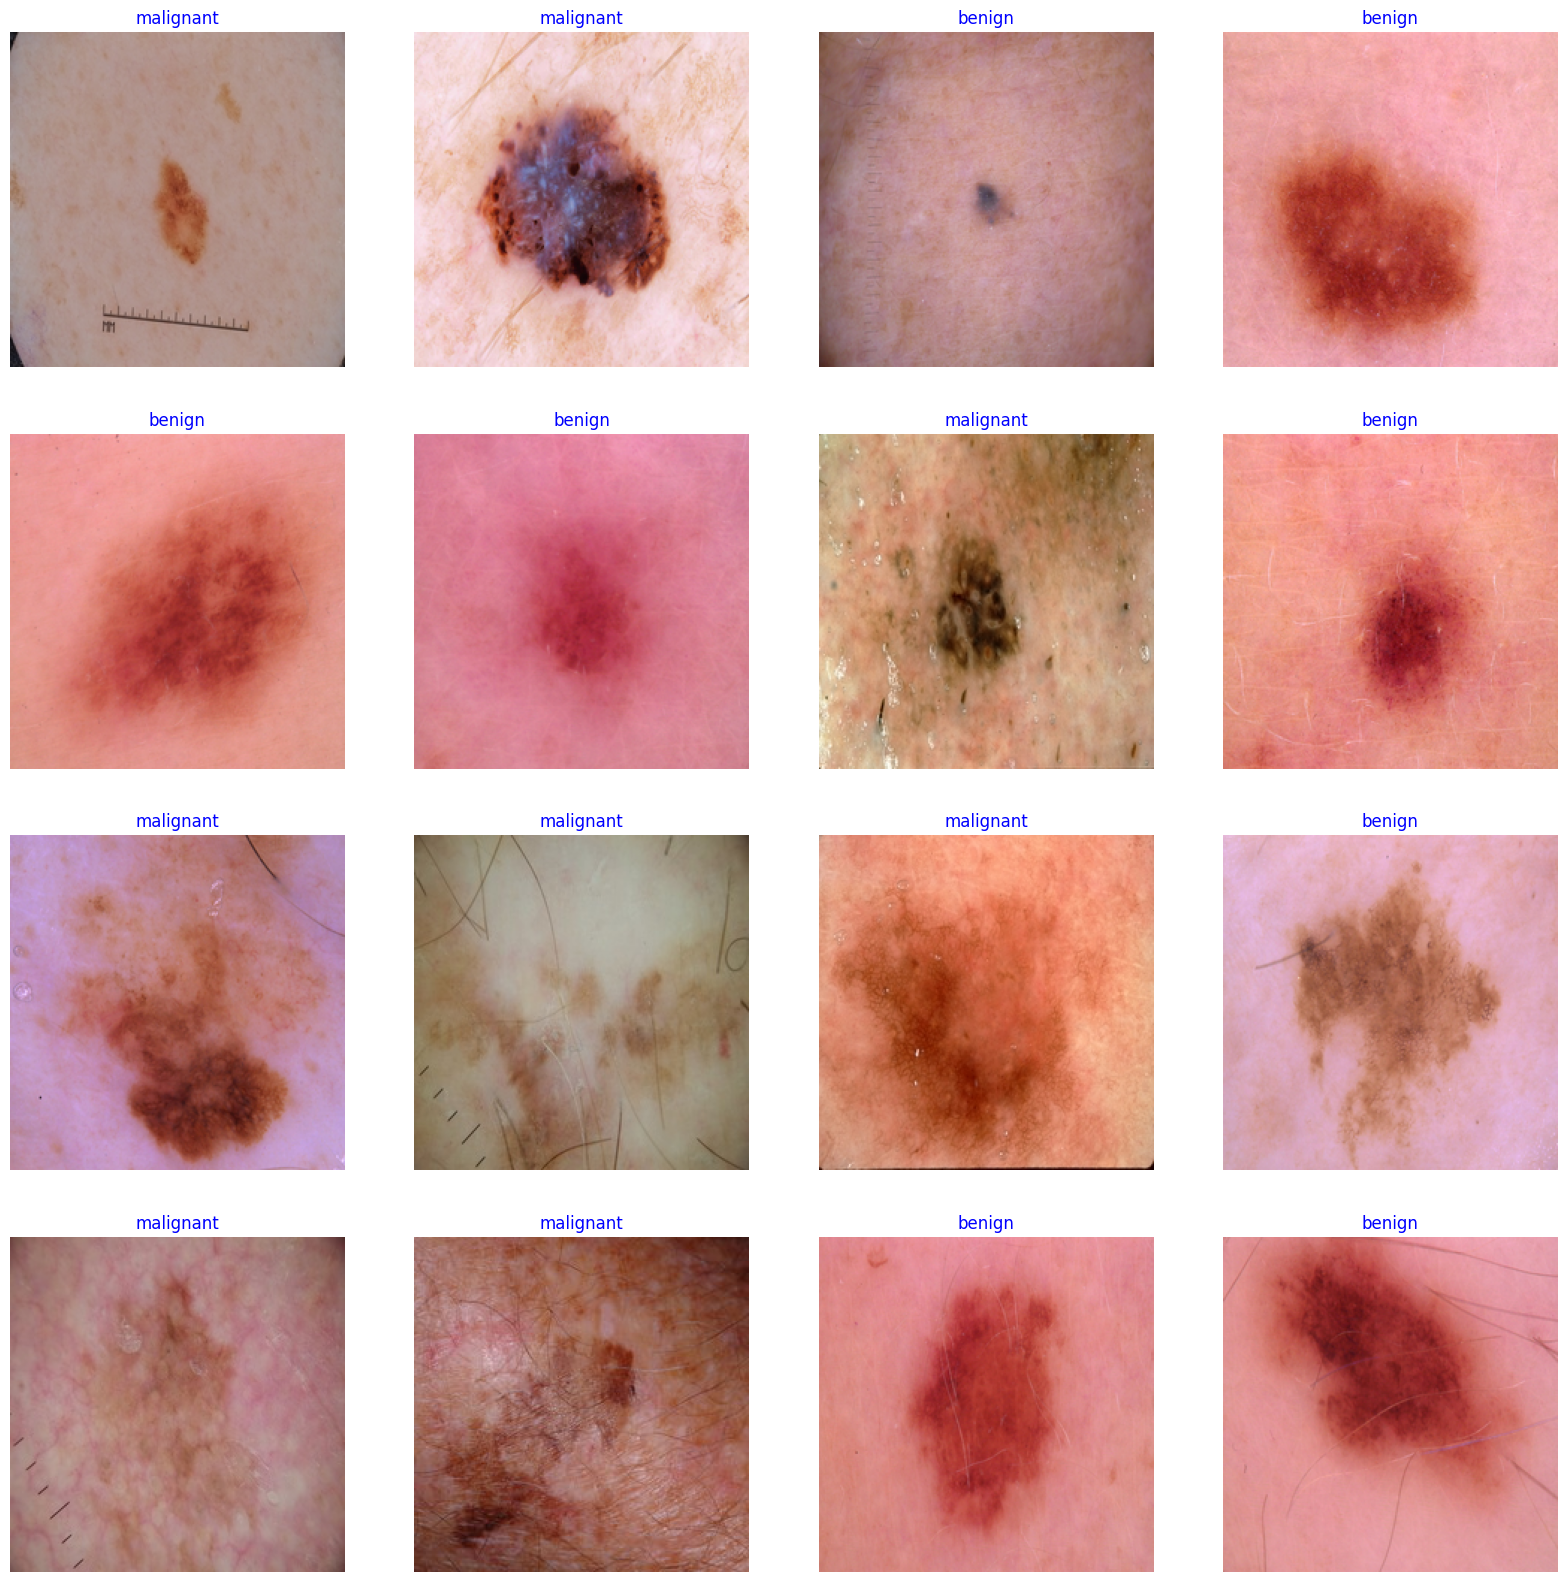

In [5]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [6]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (224,224,3))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

In [7]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [8]:
history1 = model.fit(train_gen,
                    validation_data = test_gen,
                     batch_size = 64,
                    epochs = 30)

Epoch 1/30


2023-10-18 07:00:04.088998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


165/165 [==============================] - 36s 148ms/step - loss: 0.5593 - accuracy: 0.7649 - val_loss: 0.7026 - val_accuracy: 0.7197
Epoch 2/30
165/165 [==============================] - 8s 47ms/step - loss: 0.4444 - accuracy: 0.7956 - val_loss: 1.0054 - val_accuracy: 0.6970
Epoch 3/30
165/165 [==============================] - 8s 47ms/step - loss: 0.4065 - accuracy: 0.8138 - val_loss: 0.6999 - val_accuracy: 0.6924
Epoch 4/30
165/165 [==============================] - 8s 46ms/step - loss: 0.3665 - accuracy: 0.8294 - val_loss: 0.5138 - val_accuracy: 0.7621
Epoch 5/30
165/165 [==============================] - 7s 45ms/step - loss: 0.3716 - accuracy: 0.8237 - val_loss: 0.3475 - val_accuracy: 0.8530
Epoch 6/30
165/165 [==============================] - 8s 46ms/step - loss: 0.3576 - accuracy: 0.8316 - val_loss: 0.4305 - val_accuracy: 0.7955
Epoch 7/30
165/165 [==============================] - 8s 47ms/step - loss: 0.3427 - accuracy: 0.8381 - val_loss: 0.4157 - val_accuracy: 0.7924
Epoch 8/

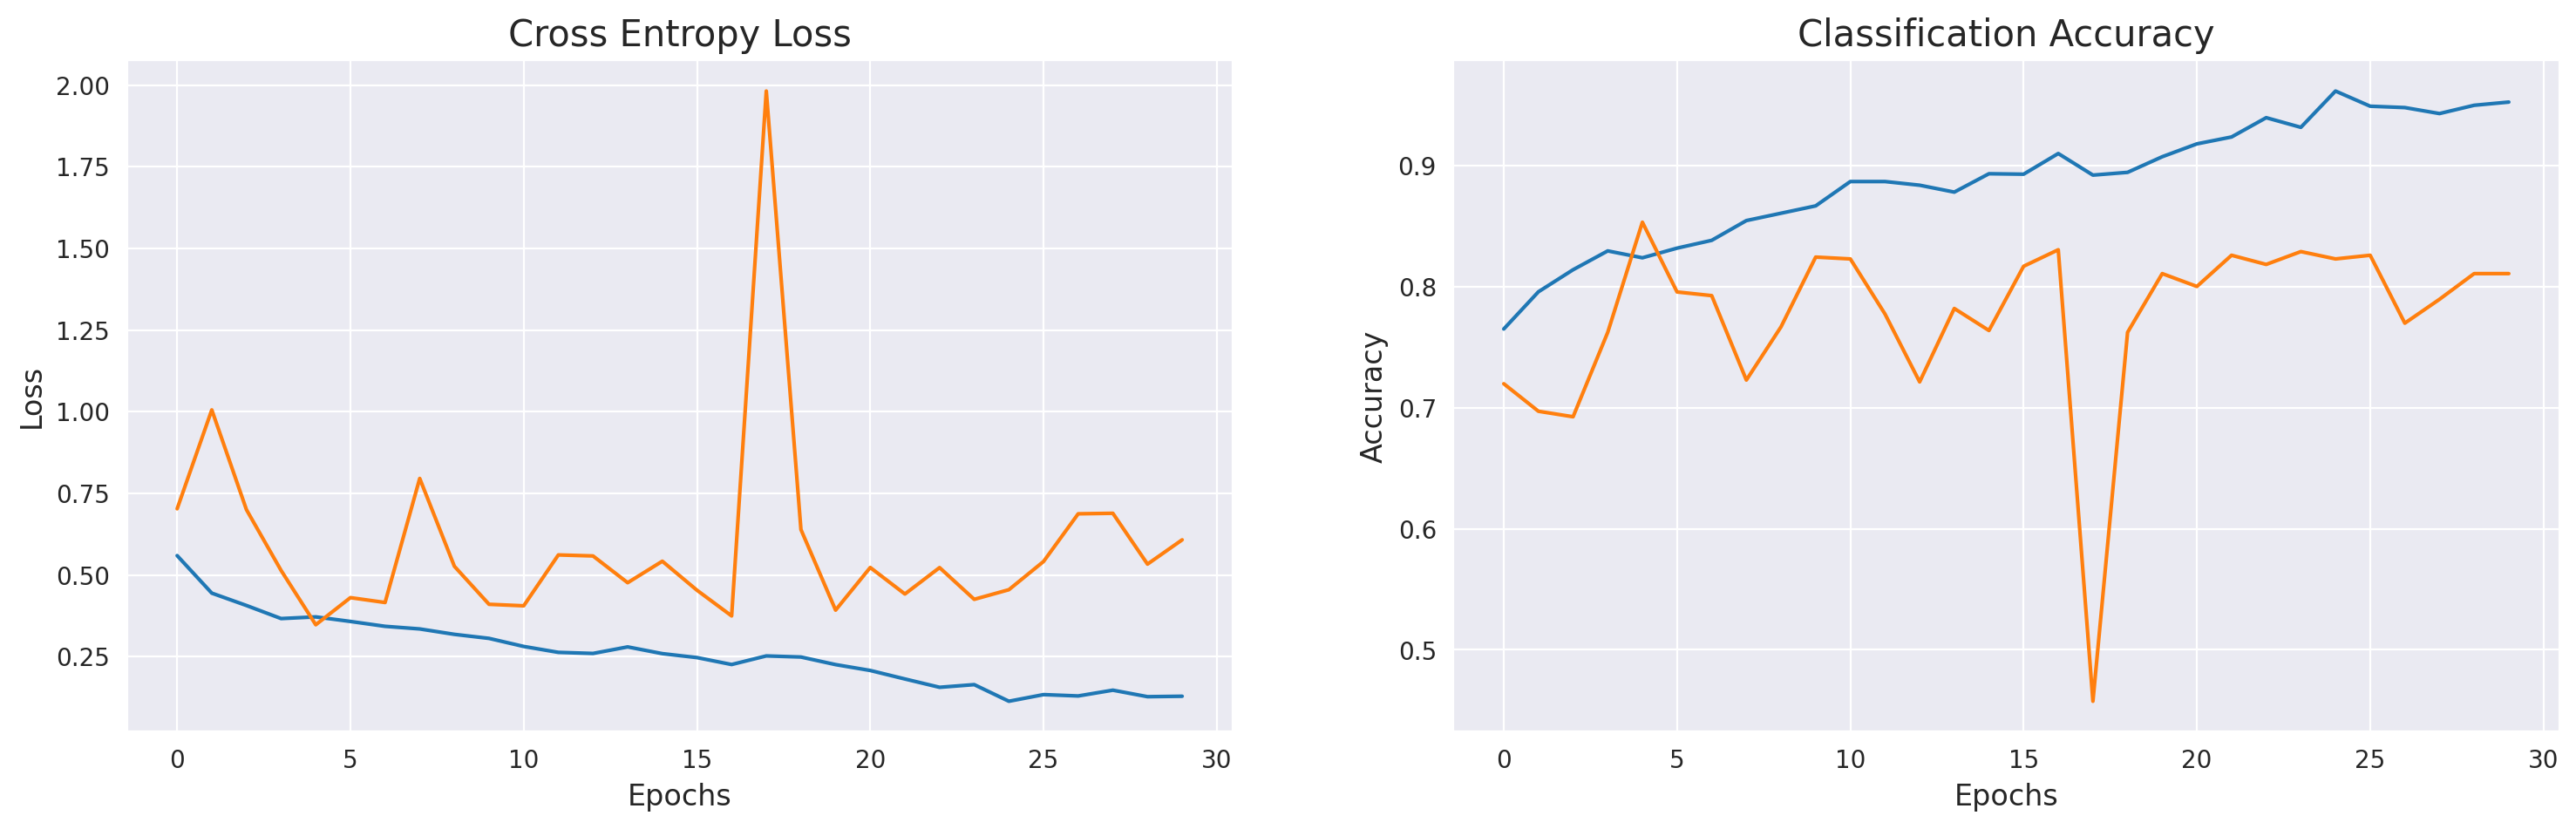

In [9]:

# plots for accuracy and Loss with epochs

error = pd.DataFrame(history1.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [10]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_gen)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(test_gen)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

165/165 [==============================] - 6s 35ms/step - loss: 0.2428 - accuracy: 0.9185
The accuracy of the model for training data is: 91.84679388999939
The Loss of the model for training data is: 0.24282212555408478
42/42 [==============================] - 1s 33ms/step - loss: 0.6076 - accuracy: 0.8106
The accuracy of the model for validation data is: 81.0606062412262
The Loss of the model for validation data is: 0.6075720191001892


In [11]:
# prediction
result = model.predict(test_gen)

y_pred = np.argmax(result, axis = 1)

y_true = test_gen.labels

# Evaluvate
loss,acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

42/42 [==============================] - 1s 34ms/step - loss: 0.6076 - accuracy: 0.8106
The accuracy of the model for testing data is: 81.0606062412262
The Loss of the model for testing data is: 0.6075720191001892


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred,target_names=classes))

              precision    recall  f1-score   support

      benign       0.79      0.89      0.84       360
   malignant       0.84      0.72      0.78       300

    accuracy                           0.81       660
   macro avg       0.82      0.80      0.81       660
weighted avg       0.81      0.81      0.81       660

